Tasca S8.01. Visualitzacions en Python: The objective is to connect to MySQL Workbench, retrieve data from database tables, and create visualizations to highlight and interpret relevant patterns in the data.

Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date
import numpy as np

# MySQL and environment handling
import mysql.connector
from mysql.connector import Error
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

Load the .env file

In [ ]:
load_dotenv()

True

In [3]:
# Load the .env file
load_dotenv()

host=os.getenv("MYSQL_HOST")
user=os.getenv("MYSQL_USER")
password=os.getenv("MYSQL_PASSWORD")
database=os.getenv("MYSQL_DB")

try:
    # Connect using mysql.connector
    connection = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )

    if connection.is_connected():
        print("✅ Connected to MySQL using mysql.connector")

    # Create SQLAlchemy engine
    engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")
    print("✅ SQLAlchemy engine created")

except Error as e:
    print("❌ Error while connecting to MySQL:", e)

finally:
    if 'connection' in locals() and connection.is_connected():
        connection.close()
        print("🔒 Connection closed")

✅ Connected to MySQL using mysql.connector
✅ SQLAlchemy engine created
🔒 Connection closed


In [4]:
company_query = "SELECT * FROM sales.company"
company = pd.read_sql(company_query, con=engine)

credit_card_query = "SELECT * FROM sales.credit_card"
credit_card = pd.read_sql(credit_card_query, con=engine)

credit_card_status_history_query = "SELECT * FROM sales.credit_card_status_history"
credit_card_status_history = pd.read_sql(credit_card_status_history_query, con=engine)

product_query = "SELECT * FROM sales.product"
product = pd.read_sql(product_query, con=engine)


transaction_query = "SELECT * FROM sales.transaction"
transaction = pd.read_sql(transaction_query, con=engine)


transaction_product_query = "SELECT * FROM sales.transaction_product"
transaction_product = pd.read_sql(transaction_product_query, con=engine)


user_query = "SELECT * FROM sales.user"
user = pd.read_sql(user_query, con=engine)


connection.close()
print("🔒 Connection closed")

🔒 Connection closed


- Exercici 1
Una variable numèrica

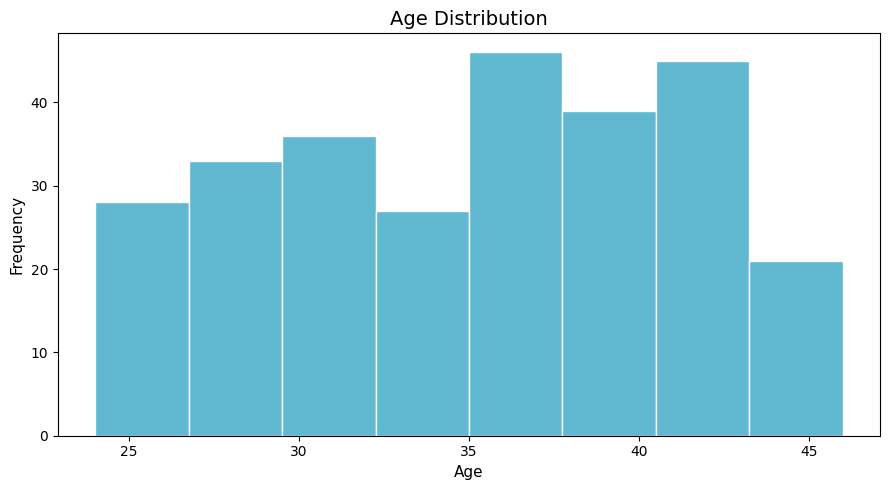

In [5]:
# calculate age and add to user
def calculate_age(born):
    born = datetime.strptime(born, "%b %d, %Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

user["age"] = user["birth_date"].apply(calculate_age)

# Freedman–Diaconis bin count
q1 = user["age"].quantile(0.25)
q3 = user["age"].quantile(0.75)
iqr = q3 - q1
bin_width = 2 * iqr / (len(user["age"]) ** (1/3))
fd_bins = int(np.ceil((user["age"].max() - user["age"].min()) / bin_width))


plt.figure(figsize=(9, 5))
sns.histplot(
    data=user,
    x="age",
    bins=fd_bins,
    color= sns.color_palette("YlGnBu")[3],
    edgecolor="white"
)
plt.title(f"Age Distribution", fontsize=14)
plt.xlabel("Age", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.tight_layout()
plt.show()

- Exercici 2
Dues variables numèriques.

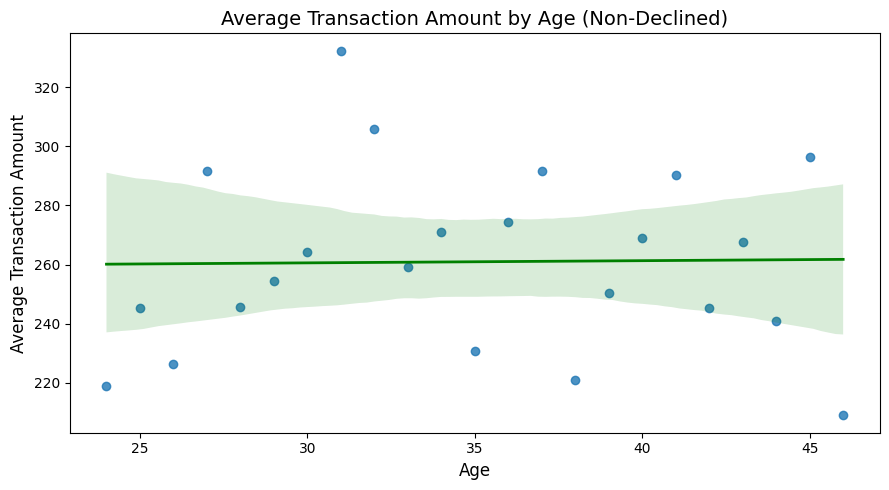

In [6]:
# add month to transaction
transaction["month"] = pd.to_datetime(transaction['timestamp']).dt.month

# keep only successful transactions
successful_transactions = transaction[transaction["declined"] == 0]

#  merge successful transactions and users
merged_successful_transactions_user = (
    pd.merge(
        successful_transactions[["id", "user_id", "amount", "declined", "month"]],
        user[["id", "age", "country"]],
        left_on="user_id",
        right_on="id",
        how="inner"
    )
    .rename(columns={"id_x": "transaction_id", "id_y": "user_id"})
   # .drop(columns=["user_id"])
)

# calculate average amount per age
avg_amount_age = merged_successful_transactions_user.groupby("age")["amount"].mean().reset_index()


plt.figure(figsize=(9, 5))
sns.regplot(
    data=avg_amount_age,
    x ="age",
    y ="amount",
    line_kws={"color": "green", "linewidth": 2}
)
plt.title("Average Transaction Amount by Age (Non-Declined)", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Average Transaction Amount", fontsize=12)
plt.tight_layout()
plt.show()

- Exercici 3
Una variable categòrica.

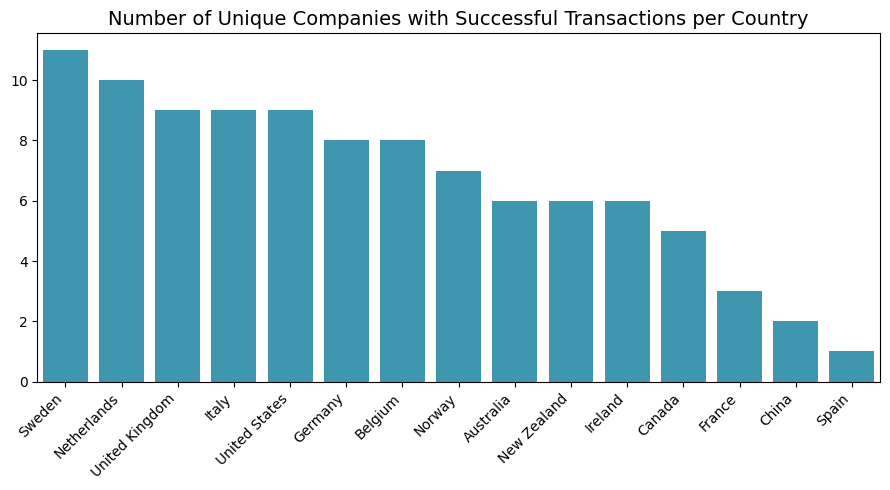

In [7]:
merged_successful_transactions_company = pd.merge(
    company[["company_id", "country"]],
    successful_transactions[["company_id"]],
    on="company_id",
    how="inner"
)

# remove duplicate companies to avoid double counting
unique_companies = merged_successful_transactions_company.drop_duplicates(subset=["company_id"])

# count number of unique companies per country
company_counts_by_country = (
    unique_companies
    .groupby("country")["company_id"]
    .count()
    .reset_index()
    .rename(columns={"company_id": "num_companies"})
    .sort_values("num_companies", ascending=False)
    .reset_index(drop=True)
)

# get sorted country list for plotting
sorted_countries = company_counts_by_country["country"]

plt.figure(figsize=(9, 5))
sns.barplot(
    data=company_counts_by_country,
    x="country",
    y="num_companies",
    color=sns.color_palette("YlGnBu")[3],
    order=sorted_countries
)

plt.xticks(rotation=45, ha="right")
plt.title("Number of Unique Companies with Successful Transactions per Country", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

- Exercici 4
Una variable categòrica i una numèrica.

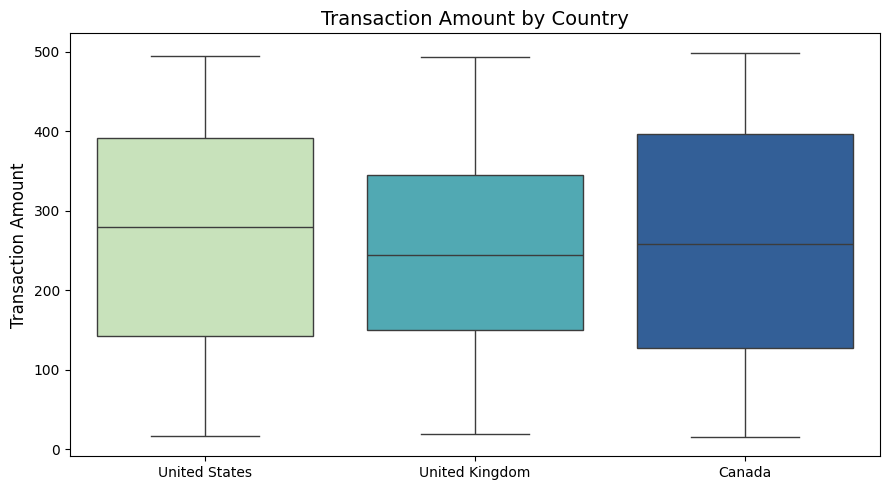

In [8]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    data=merged_successful_transactions_user,
    x = "country",
    y = "amount",
    hue="country",
    legend=False,
    palette= "YlGnBu"
)

plt.title("Transaction Amount by Country", fontsize=14)
plt.xlabel("")
plt.ylabel("Transaction Amount", fontsize=12)
plt.tight_layout()
plt.show()



- Exercici 5
Dues variables categòriques.

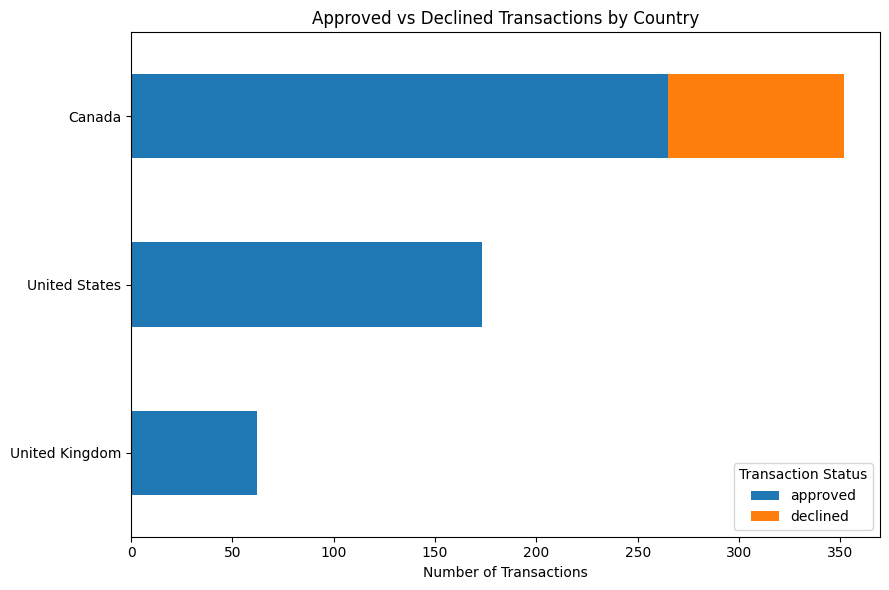

In [9]:
# merge and rename
df_all_transaction_user = pd.merge(
    user[["id", "country", "age"]],
    transaction[["user_id", "declined", "amount"]],
    left_on="id",
    right_on="user_id",
    how="inner"
).rename(columns={"id": "user_id"})

# summarize by country
summary_transaction = df_all_transaction_user.groupby('country')['declined'].agg(
    total='count',
    declined='sum'
).reset_index()

summary_transaction['approved'] = summary_transaction['total'] - summary_transaction['declined']

# prepare data for plotting
plot_data = summary_transaction.set_index("country")[["approved", "declined"]] \
    .sort_values(by=["approved", "declined"])


plot_data.plot(kind="barh", stacked=True, figsize=(9, 6))
plt.title("Approved vs Declined Transactions by Country")
plt.xlabel("Number of Transactions")
plt.ylabel("")
plt.legend(title="Transaction Status", loc="lower right")
plt.tight_layout()
plt.show()


- Exercici 6
Tres variables.

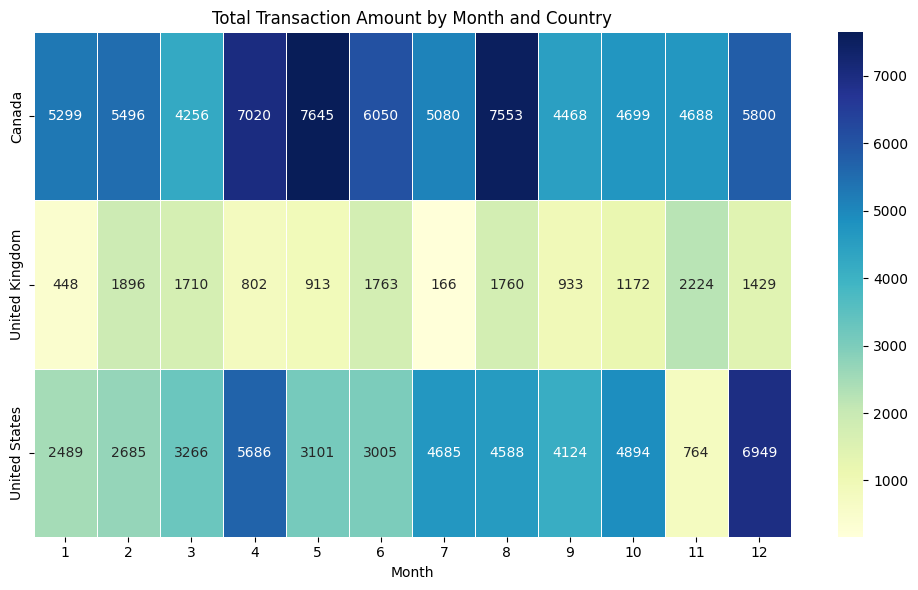

In [10]:
df_monthly_sales = merged_successful_transactions_user.groupby(['country', 'month'])['amount'].sum().reset_index()

# pivot for heatmap (rows = country, cols = month)
sales_pivot = df_monthly_sales.pivot(index='country', columns='month', values='amount')

plt.figure(figsize=(10, 6))
sns.heatmap(sales_pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Total Transaction Amount by Month and Country")
plt.xlabel("Month")
plt.ylabel("")
plt.tight_layout()
plt.show()

- Exercici 7
Graficar un Pairplot.

<Figure size 1000x600 with 0 Axes>

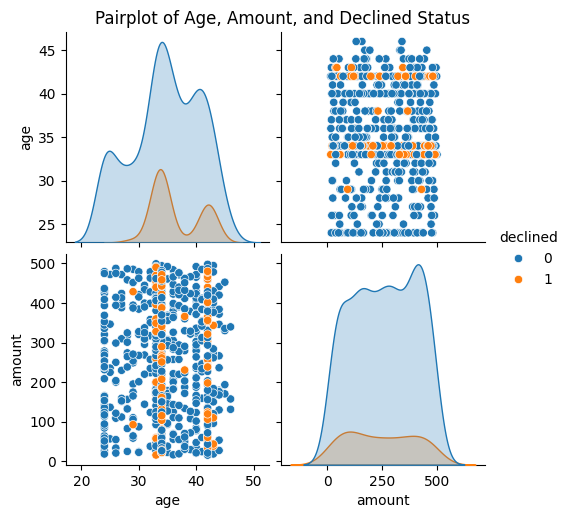

In [11]:
pairplot_data = df_all_transaction_user[["age", "amount", "declined"]]
plt.figure(figsize=(10, 6))
sns.pairplot(data=pairplot_data, hue="declined")
plt.suptitle("Pairplot of Age, Amount, and Declined Status", y=1.02)
plt.show()


Nivell 2
Exercici 1
Correlació de totes les variables numèriques.

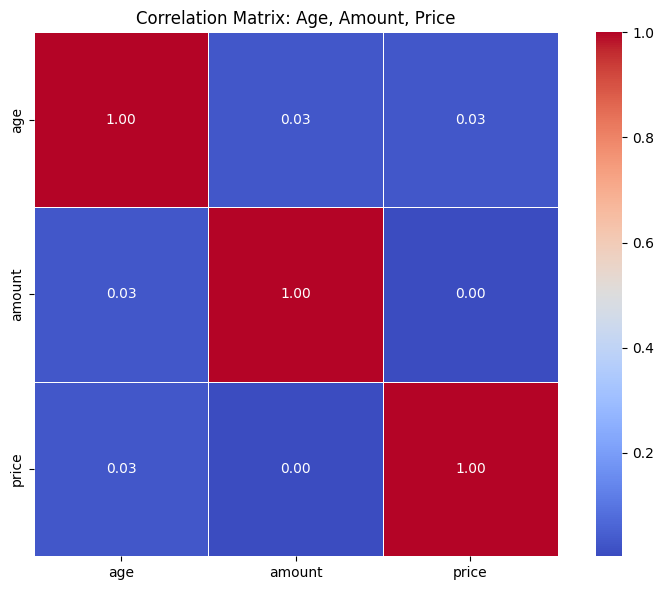

In [16]:
successful_transactions_user_product = pd.merge(
    merged_successful_transactions_user,
    transaction_product[["transaction_id", "product_id"]],
    on="transaction_id",
    how="inner"
)

# STEP 3: Merge with product table to get price
successful_transactions_user_product_price = pd.merge(
    successful_transactions_user_product,
    product[["id", "price"]],
    left_on="product_id",
    right_on="id",
    how="inner"
).rename(columns={"id": "product_id"})

corr_data = successful_transactions_user_product_price[["age", "amount", "price"]]
correlation_data = corr_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Matrix: Age, Amount, Price")
plt.tight_layout()
plt.show()



Exercici 2
Implementa un jointplot.

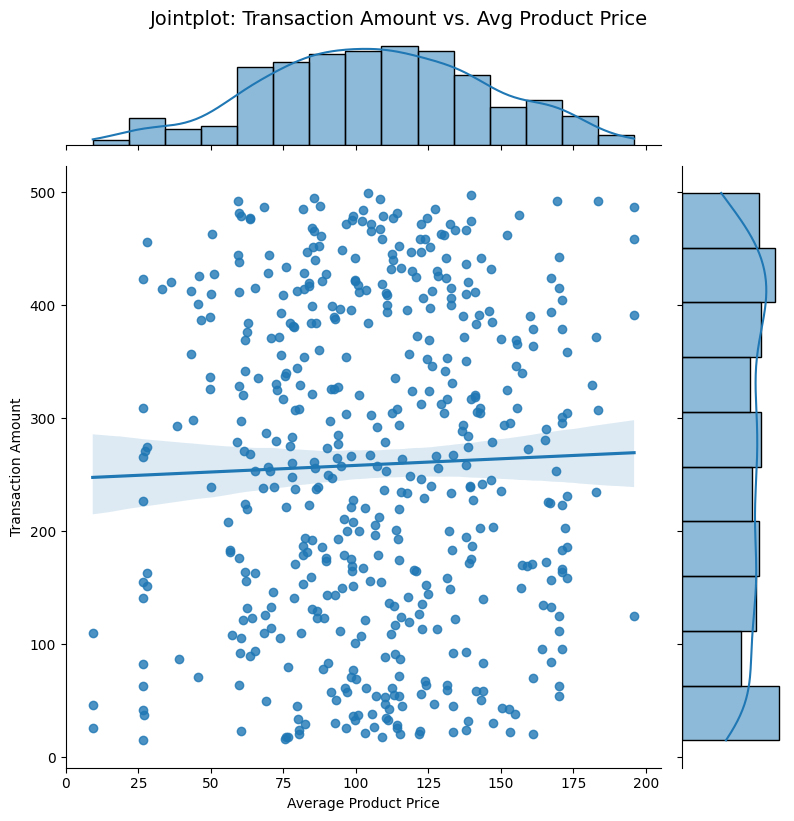

In [13]:
avg_price = successful_transactions_user_product_price.groupby("transaction_id")["price"].mean().reset_index()

# add transaction amount (as it is duplicated in successful_transactions_user_product_price)
transaction_amount = transaction[["id", "amount"]].rename(columns={"id": "transaction_id"})
transaction_amount_avg_price = pd.merge(transaction_amount, avg_price, on="transaction_id")

# Create jointplot
sns.jointplot(
    data = transaction_amount_avg_price,
    x="price",
    y="amount",
    kind="reg",
    height=8,
)

plt.suptitle("Jointplot: Transaction Amount vs. Avg Product Price", fontsize=14, y=1.02)
plt.xlabel("Average Product Price")
plt.ylabel("Transaction Amount")
plt.show()

Nivell 3
Exercici 1
Implementa un violinplot combinat amb un altre tipus de gràfic.

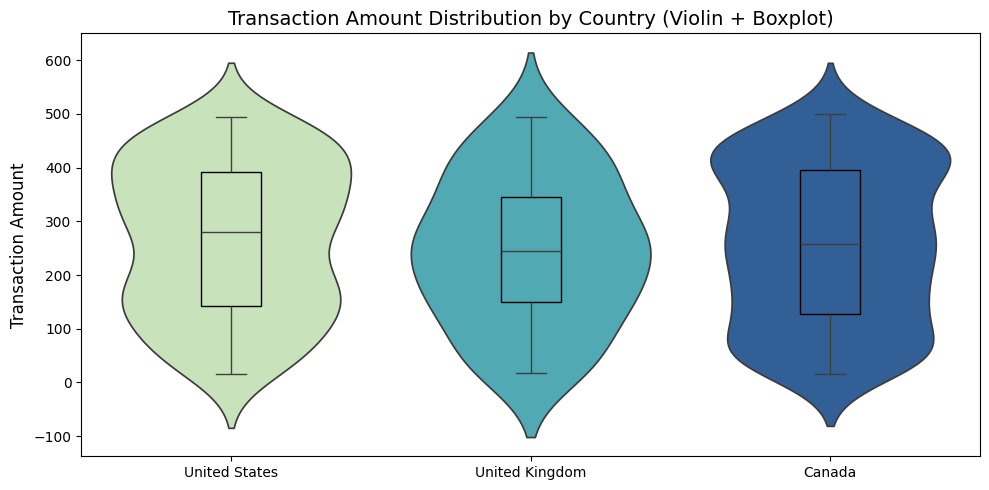

In [14]:
plt.figure(figsize=(10, 5))

sns.violinplot(
    data=merged_successful_transactions_user,
    x = "country",
    y = "amount",
    hue="country",
    legend=False,
    inner=None,
    palette= "YlGnBu"
)

sns.boxplot(
    data=merged_successful_transactions_user,
    x = "country",
    y = "amount",
    width=0.2,
    boxprops={'facecolor': 'none', 'edgecolor': 'black'},
)

plt.title("Transaction Amount Distribution by Country (Violin + Boxplot)", fontsize=14)
plt.xlabel("")
plt.ylabel("Transaction Amount", fontsize=12)
plt.tight_layout()
plt.show()

Exercici 2
Genera un FacetGrid per a visualitzar múltiples aspectes de les dades simultàniament.

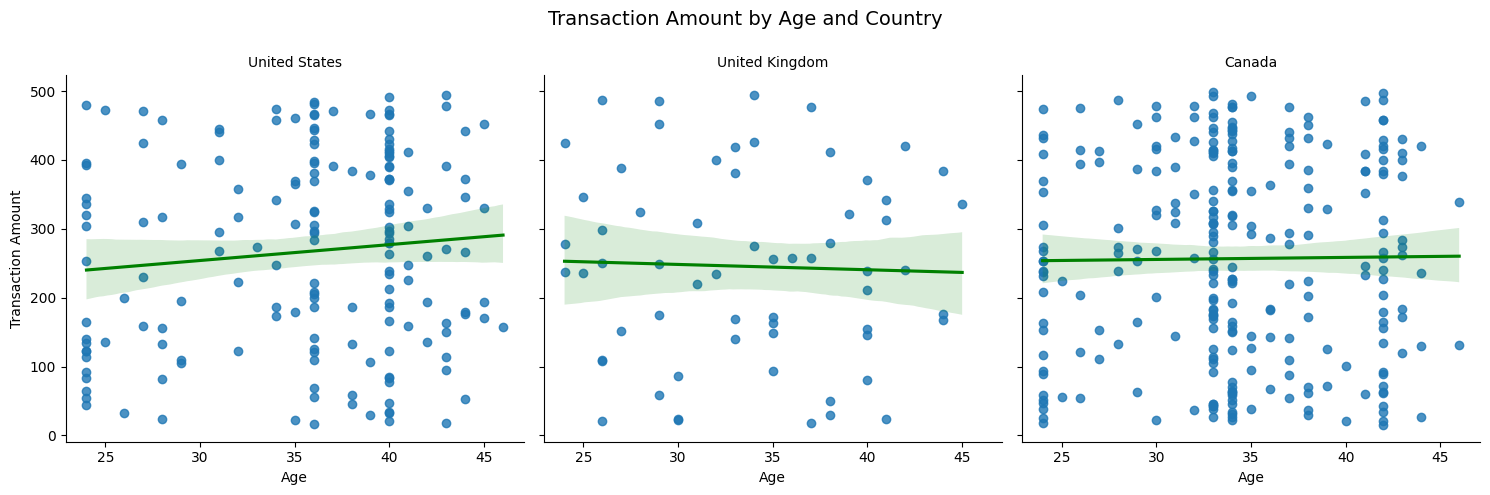

In [15]:
fg = sns.FacetGrid(
    merged_successful_transactions_user, 
    col = "country", 
    height=5, 
    aspect=1
)

fg.map_dataframe(
    sns.regplot, 
    x = "age", 
    y = "amount", 
    line_kws={'color': 'green'}
)

fg.set_axis_labels("Age", "Transaction Amount")
fg.set_titles("{col_name}")
fg.figure.subplots_adjust(top=0.85)
fg.figure.suptitle("Transaction Amount by Age and Country", fontsize=14)
plt.show()
